#Worker analysis of job #758438

Tong Shu Li<br>
Created on Saturday 2015-08-01<br>
Last updated 2015-08-13

#### Automatically flag workers who take the quiz but only use one response time, and perform their responses really quickly. These workers may be the slave accounts of cheaters who memorize the test question answers.

In this notebook we take a look at the workers of CrowdFlower job #758438 and try to eliminate the cheaters.

In [1]:
from __future__ import division
from collections import defaultdict
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pycountry
import random

In [2]:
random.seed("2015-08-03:14:03")

In [3]:
NUMPY_RAND_SEED = 993402
WORK_UNITS_PER_PAGE = 6

In [4]:
matplotlib inline

---

In [5]:
def convert_time(text):
    """
    Given the time in CrowdFlower's output format,
    convert it to a Python datetime object.
    CrowdFlower time stamps are in UTC.
    
    CrowdFlower timestamps have the following format:
    
    month/day/year hour:minute:second
    
    Example:
    
    8/2/2015 00:26:24
    """
    return dt.datetime.strptime(text, "%m/%d/%Y %H:%M:%S")

def time_elapsed(start, stop):
    """
    Given two Python datetime objects, determines the number
    of seconds between those two times.
    """
    seconds = int((stop - start).total_seconds())
    assert seconds >= 0
    return seconds

def determine_time_taken(dataframe):
    """
    Given a dataframe with the responses from one worker,
    determines the time taken for one page of work.
    """
    def time_taken_wrapper(row):
        return time_elapsed(row[0], row[1])
    
    if dataframe.empty:
        return pd.Series()
    
    time_taken = dataframe[["_started_at", "_created_at"]].apply(time_taken_wrapper, axis = 1)
    return time_taken

def time_stats(time_series):
    """
    Given the time taken for each individual work unit,
    determines some stats.
    """
    return (time_series.min(), time_series.median(), time_series.max())

def get_country_name(code):
    if isinstance(code, str):
        return pycountry.countries.get(alpha3 = code).name.split(",")[0]
    
    # code is missing (NaN)
    return "unknown"

###Read the raw data:

In [6]:
raw_data = pd.read_csv("data/crowdflower/results/job_758438_full_with_untrusted.csv", sep = ",")

In [7]:
raw_data.loc[:, "_created_at"] = raw_data.loc[:, "_created_at"].map(convert_time)
raw_data.loc[:, "_started_at"] = raw_data.loc[:, "_started_at"].map(convert_time)

---

In [8]:
def build_worker_profiles(raw_data):
    """
    Build a profile for every worker that tried the task.
    """
    res = defaultdict(list)
    
    metadata = ["_trust", "_ip", "_channel"]
    ans_choices = ["yes_direct", "yes_indirect", "no_relation", "ner_mistake"]
    
    for worker_id, group in raw_data.groupby("_worker_id"):
        test_resp = group.query("_golden")
        work_resp = group.query("~_golden")
        
        res["worker_id"].append(worker_id)
        res["test_ques_seen"].append(len(test_resp["uniq_id"].unique()))
        res["work_units_seen"].append(len(work_resp["uniq_id"].unique()))
        
        res["country"].append(get_country_name(test_resp["_country"].iloc[0]))
        
        for metadata_col in metadata:
            res[metadata_col.lstrip("_")].append(test_resp[metadata_col].iloc[0])
            
        for work_type, resp_data in zip(["test", "work"], [test_resp, work_resp]):
            time_series = determine_time_taken(resp_data) # time per page
            time_series /= WORK_UNITS_PER_PAGE # time per work unit
            
            stats = time_stats(time_series)
            for i, name in enumerate(["min", "median", "max"]):
                res["{0}_{1}_time_per_unit".format(work_type, name)].append(stats[i])
                
            # look at the response distributions
            for ans_choice in ans_choices:
                temp = resp_data.query("verify_relationship == '{0}'".format(ans_choice))
                res["{0}_{1}".format(work_type, ans_choice)].append(len(temp["uniq_id"].unique()))
        
    return pd.DataFrame(res)

In [9]:
worker_profiles = build_worker_profiles(raw_data)

In [10]:
worker_profiles.head()

,channel,country,ip,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_seen,test_yes_direct,...,trust,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
0,points2shop,United States,23.119.108.175,73.166667,73.166667,73.166667,1,2,6,2,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,3694955
1,clixsense,Philippines,49.144.240.111,113.333333,113.333333,113.333333,1,2,6,3,...,0.6667,NaN,NaN,NaN,0,0,0,0,0,6332651
2,clixsense,Mexico,189.202.57.112,209.333333,209.333333,209.333333,0,4,6,2,...,0.6667,NaN,NaN,NaN,0,0,0,0,0,6347829
3,clixsense,Canada,70.50.92.191,170.833333,170.833333,170.833333,0,2,6,3,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,6450461
4,clixsense,United States,67.247.11.75,85.833333,85.833333,85.833333,0,1,6,2,...,0.1667,NaN,NaN,NaN,0,0,0,0,0,7051387


### Calculate trust over time:

In [11]:
def trust_over_time(dataframe):
    res = defaultdict(list)

    list_size = 0
    for worker_id, resp in dataframe.groupby("_worker_id"):
        cum_seen = 0
        cum_missed = 0
        for fin_time, page in resp.groupby("_created_at"):
            seen = page["_golden"].sum()
            missed = page["_missed"].sum()
            
            if np.isnan(missed):
                missed = 0
                
            cum_seen += seen
            cum_missed += missed
            res[worker_id].append(1 - cum_missed / cum_seen)
            
        list_size = max(list_size, len(res[worker_id]))
        
    temp = dict()
    for worker_id, values in res.items():
        temp[worker_id] = values + [np.nan] * (list_size - len(values))
        
    return pd.DataFrame(temp)

In [12]:
timeres = trust_over_time(raw_data)

In [13]:
timeres.head()

,3694955,6332651,6347829,6450461,7051387,7211526,8375045,8841252,9832767,11026819,...,33596095,33605234,33623160,33634654,33640330,33664647,33669016,33693322,33705733,33721948
0,0.5,0.666667,0.666667,0.5,0.166667,0.166667,0.666667,0.666667,1.000000,0.5,...,1,1.000000,0.666667,0.5,1.000000,0.833333,0,0.666667,0.5,0.833333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,1,0.857143,NaN,NaN,1.000000,0.714286,NaN,NaN,NaN,0.857143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875000,NaN,...,1,0.750000,NaN,NaN,1.000000,0.750000,NaN,NaN,NaN,0.875000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,NaN,...,NaN,0.777778,NaN,NaN,0.888889,0.666667,NaN,NaN,NaN,0.888889
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.700000,NaN,...,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900000


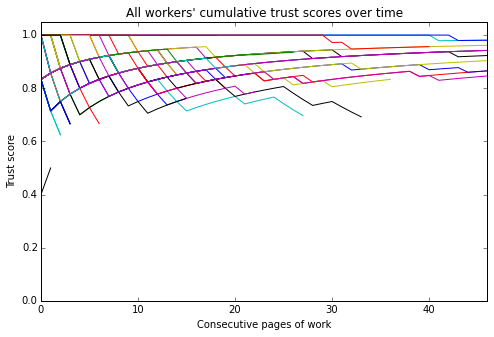

In [14]:
graph = timeres.plot(legend = False, figsize = (8, 5),
            title = "All workers' cumulative trust scores over time")

graph.set_ylim((0, 1.05))
graph.set_xlabel("Consecutive pages of work")
graph.set_ylabel("Trust score")

### Examine answer response distribution over time:

In [15]:
def resp_over_time(dataframe):
    testres = []
    workres = []
    time_taken = []
    
    # for one worker only
    for fin_time, page in dataframe.groupby("_created_at"):
        test_dist = page.query("_golden")["verify_relationship"].value_counts(normalize = True)
        work_dist = page.query("~_golden")["verify_relationship"].value_counts(normalize = True)
        
        start_time = page["_started_at"].iloc[0].to_datetime()
        stop_time = page["_created_at"].iloc[0].to_datetime()
        
        time_used = int((stop_time - start_time).total_seconds())
        
        testres.append(test_dist)
        workres.append(work_dist)
        time_taken.append(time_used)
        
    testres = pd.DataFrame(testres).fillna(0)
    workres = pd.DataFrame(workres).fillna(0)
    
    return (pd.Series(time_taken), testres, workres)

def plot_worker_resp(job_id, worker_id, dataframe):
    data = dataframe.query("_worker_id == {0}".format(worker_id))
    
    time_taken, testres, workres = resp_over_time(data)
    
    trust_time = timeres[worker_id].dropna()
    
    
    fig, axs = plt.subplots(4, 1, figsize = (10, 19))
    
    fig.suptitle("Profile for worker {0} for job {1}".format(worker_id, job_id, fontsize = 20))

    for i in range(3):
        axs[i].set_ylim((0, 1.05))
    
    axs[0].set_xlabel("Pages of work in ascending time order")
    
    axs[0].set_ylabel("Cumulative trust score")
    axs[1].set_ylabel("% of responses")
    axs[2].set_ylabel("% of responses")
    axs[3].set_ylabel("Time used for one page of work in seconds")
    
    trust_time.plot(ax = axs[0],
                   title = "Cumulative trust score over time")
    
    testres.plot(ax = axs[1],
                title = "Test question distribution")
    workres.plot(ax = axs[2],
                title = "Work unit distribution")
    
    time_taken.plot(ax = axs[3],
                   title = "Time spent on each page of work in seconds")
    
    plt.savefig("data/worker_profiles/job_{0}/worker_{1}_profile.png".format(job_id, worker_id))
    plt.close(fig)
                     

In [16]:
bad_workers = {31501233,
 31720388,
 31720815,
 32025293,
 33081102,
 33081299,
 33081469,
 33081531,
 33085305,
 33085428,
 33238902,
 33301062,
 33301138,
 33596095}

In [17]:
job_id = 758438
for worker_id in bad_workers:
    plot_worker_resp(job_id, worker_id, raw_data)

###Building a profile about each worker:

Work units are presented to workers in pages. For our task, we had 6 work units per page. A page of work is rendered at "_started_at" time and the judgement is accepted at "_created_at" time. Therefore to determine the average time spent on a single work unit, we divide by 6.

---

###Workers who took the test but did so very quickly and only chose one answer choice:

In [13]:
def find_quiz_bots(raw_data):
    test_data = raw_data.query("_golden")
    
    bots = set()
    for worker_id, resp in test_data.groupby("_worker_id"):
        distribution = resp["verify_relationship"].value_counts()
        if len(distribution) == 1:
            bots.add(worker_id)
            
    return bots

In [14]:
quiz_bots = find_quiz_bots(raw_data)

In [15]:
quiz_bots

{11026819,
 22095664,
 24118190,
 26075686,
 30655707,
 30921821,
 31720248,
 31756422,
 32160874,
 32664120,
 32730320,
 33065741,
 33269250,
 33595991,
 33669016}

Workers who take the quiz but who never try to vary their answer response are very likely to be bots or people who are praying that the distribution for the test questions is bad enough that they will pass through anyways. If the judgements are made super quickly, despite the fact the task is hard, then this increases the likelihood that the the worker is a robot. A human would be incentivized to take as long as needed on the test questions, since that would allow them to access the task and get paid. A robot does not care, since its purpose is to feed data to the robot that allows the person to get paid.

In [16]:
df = worker_profiles.query("worker_id in {0}".format(list(quiz_bots)))
df = df.sort("test_median_time_per_unit")

In [17]:
df

,channel,country,ip,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_seen,test_yes_direct,...,trust,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
151,neodev,Viet Nam,1.52.163.51,3.666667,3.666667,3.666667,6,0,6,0,...,0.0000,NaN,NaN,NaN,0,0,0,0,0,32730320
45,neodev,Venezuela,186.93.216.65,10.500000,10.500000,10.500000,0,0,6,6,...,0.0000,NaN,NaN,NaN,0,0,0,0,0,24118190
42,instagc,United States,63.137.145.225,13.166667,13.166667,13.166667,0,0,6,6,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,22095664
163,neodev,India,27.97.173.115,19.833333,19.833333,19.833333,0,6,6,0,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,33065741
204,neodev,Viet Nam,1.52.163.51,20.000000,20.000000,20.000000,6,0,6,0,...,0.0000,NaN,NaN,NaN,0,0,0,0,0,33669016
50,clixsense,Spain,178.139.106.224,20.666667,20.666667,20.666667,0,6,6,0,...,0.3333,NaN,NaN,NaN,0,0,0,0,0,26075686
133,elite,Viet Nam,1.52.163.51,21.500000,21.500000,21.500000,6,0,6,0,...,0.0000,NaN,NaN,NaN,0,0,0,0,0,32160874
113,elite,Viet Nam,115.76.94.63,28.000000,28.000000,28.000000,0,0,6,6,...,0.1667,NaN,NaN,NaN,0,0,0,0,0,31720248
197,neodev,Viet Nam,113.189.127.72,52.833333,52.833333,52.833333,0,0,6,6,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,33595991
9,neodev,Malaysia,175.136.23.48,54.666667,54.666667,54.666667,0,0,6,6,...,0.5000,NaN,NaN,NaN,0,0,0,0,0,11026819


In [18]:
for worker_id in df.query("test_max_time_per_unit < 30")["worker_id"]:
    print "https://crowdflower.com/jobs/758438/contributors/{0}".format(worker_id)

https://crowdflower.com/jobs/758438/contributors/32730320
https://crowdflower.com/jobs/758438/contributors/24118190
https://crowdflower.com/jobs/758438/contributors/22095664
https://crowdflower.com/jobs/758438/contributors/33065741
https://crowdflower.com/jobs/758438/contributors/33669016
https://crowdflower.com/jobs/758438/contributors/26075686
https://crowdflower.com/jobs/758438/contributors/32160874
https://crowdflower.com/jobs/758438/contributors/31720248


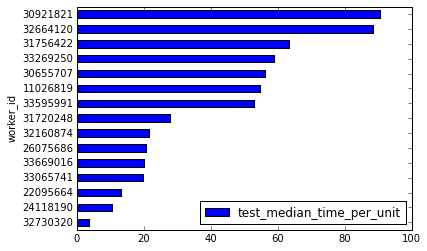

In [19]:
df.plot(kind = "barh", x = "worker_id", y = "test_median_time_per_unit")

The threshold of 30 seconds is admittedly arbitrary. However, it is **highly** unlikely that worker 32730320 is not a robot, since each judgement was made in 3 seconds, and all the responses were "ner_mistake", which is statistically the least likely choice of all the answers (the test question distribution reflects this).

However, if we consider it from the angle of a robot trying to get the right answers, then a robot would **want** to choose the wrong answers, since then it is guaranteed to be told what the correct answer is.

---

###Worker country distribution

Let's get some demographic data about the people who worked on our job.

In [20]:
def plot_by_group(column, dataframe, title):
    countries = dataframe[column].value_counts()
    
    graph = countries.plot(kind = "barh", figsize = (10, 10),
                           title = title,
                           fontsize = 12)

    graph.set_xlabel("Number of workers")

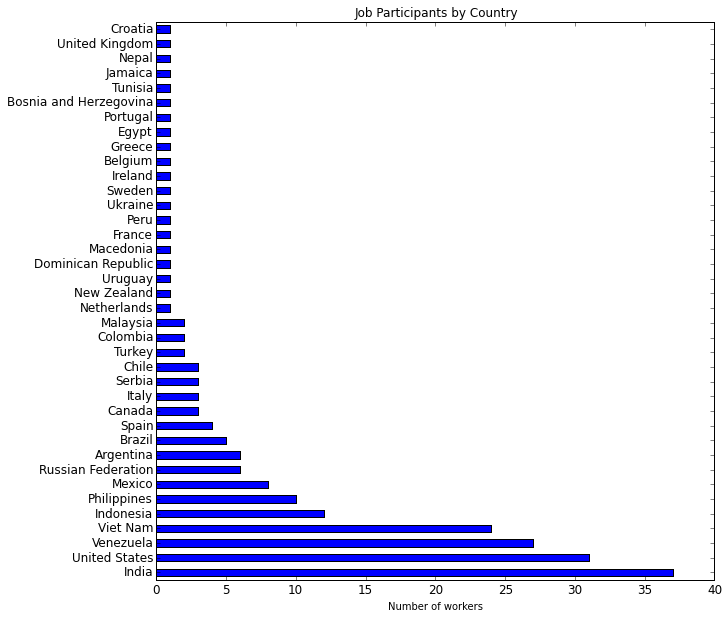

In [21]:
# all workers, including those who failed
plot_by_group("country", worker_profiles, "Job Participants by Country")

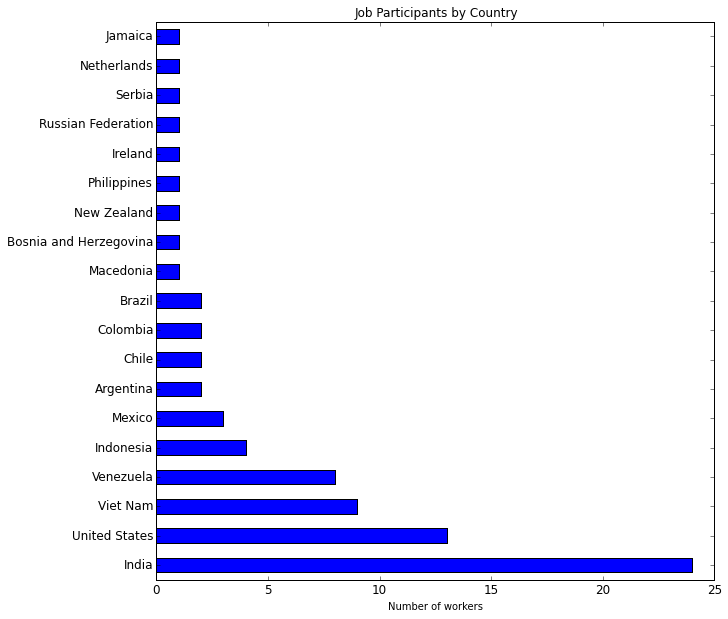

In [22]:
# workers who passed only
temp = worker_profiles.query("trust >= 0.7")
plot_by_group("country", temp, "Job Participants by Country")

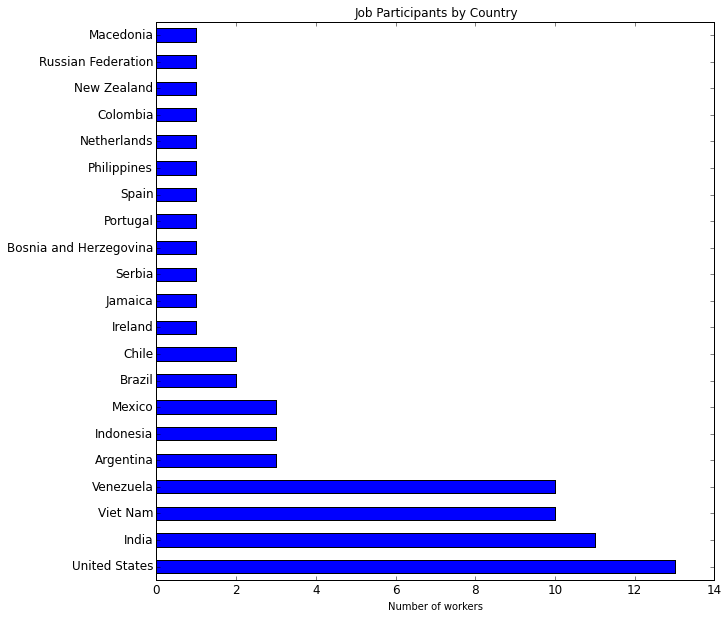

In [23]:
temp = worker_profiles.query("work_units_seen > 0")
plot_by_group("country", temp, "Job Participants by Country")

###Workers grouped by channel:

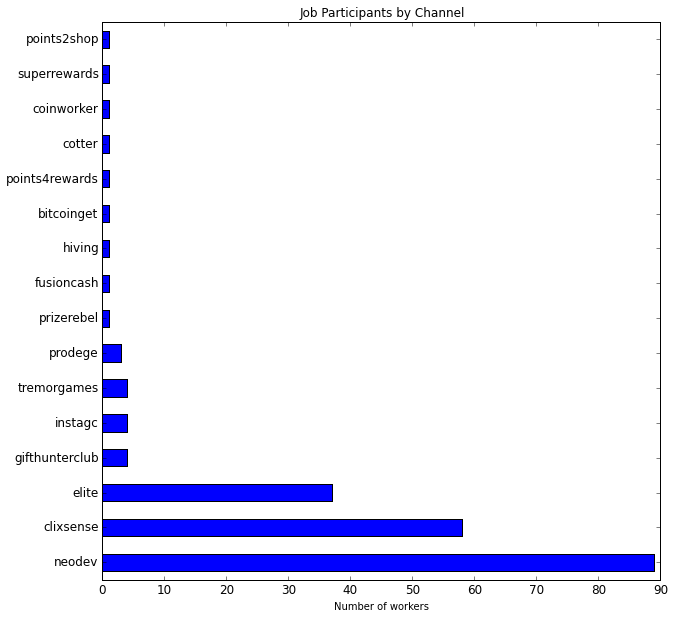

In [24]:
plot_by_group("channel", worker_profiles, "Job Participants by Channel")

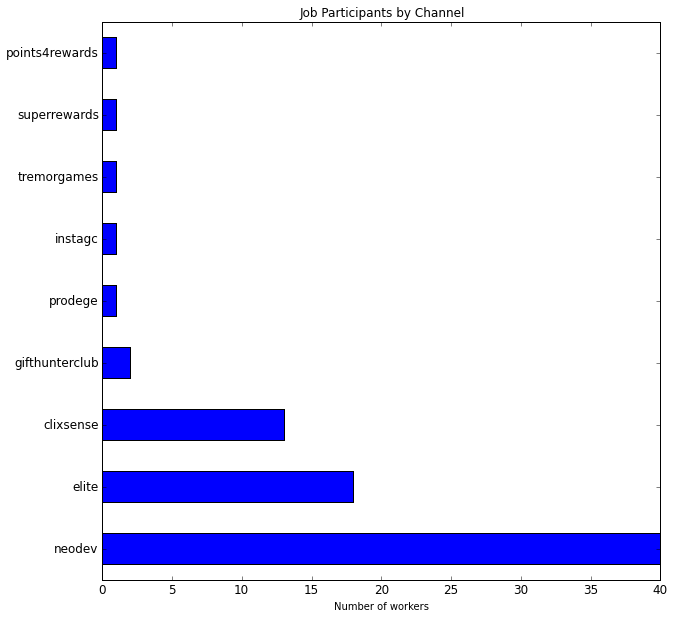

In [25]:
# workers who passed only
temp = worker_profiles.query("trust >= 0.7")
plot_by_group("channel", temp, "Job Participants by Channel")

###Median work times grouped by country

In [26]:
def plot_work_speed(column, dataframe, title):
    """
    Plot speed of work.
    """
    graph = dataframe.boxplot("work_median_time_per_unit", by = column, figsize = (10, 10),
                     rot = 75, fontsize = 12)

    graph.set_ylabel("Median work unit response time in seconds")
    graph.set_title(title)

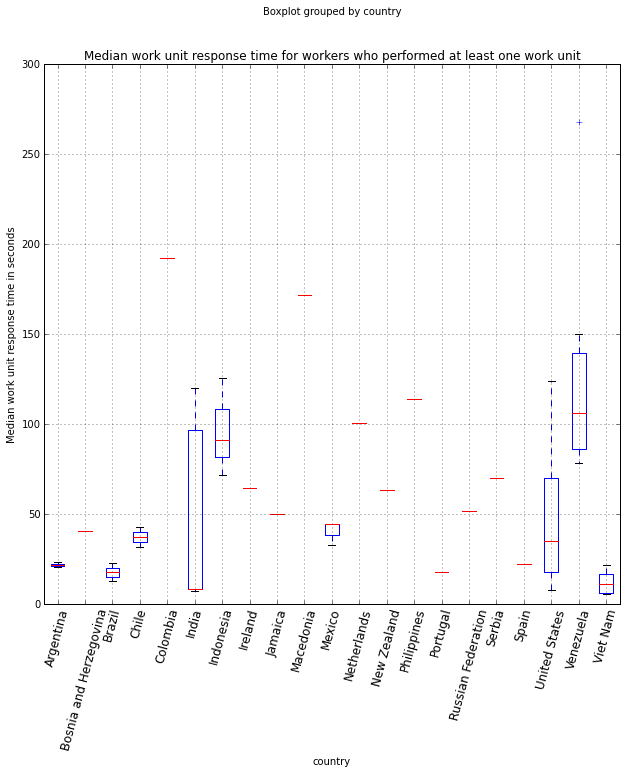

In [27]:
data = worker_profiles.query("work_units_seen > 0")
plot_work_speed("country", data, "Median work unit response time for workers who performed at least one work unit")

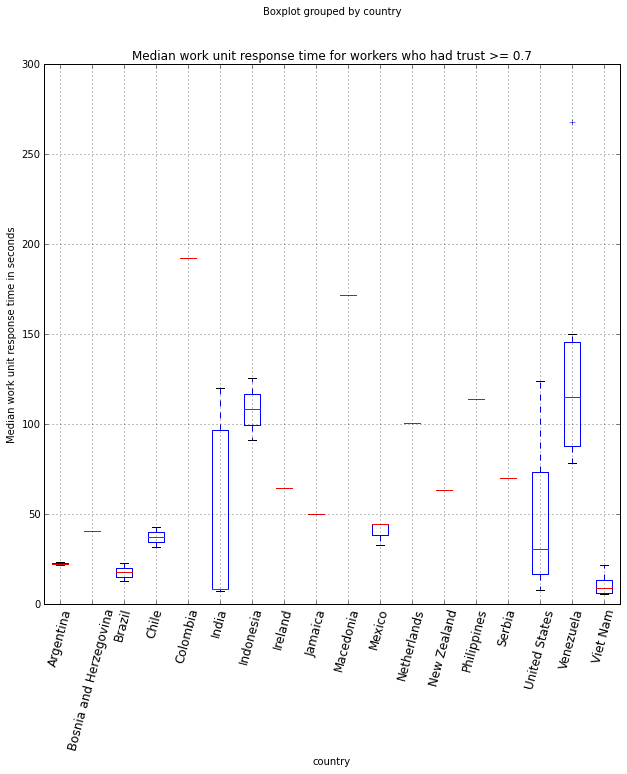

In [28]:
data = worker_profiles.query("work_units_seen > 0 and trust >= 0.7")
plot_work_speed("country", data, "Median work unit response time for workers who had trust >= 0.7")

From these two graphs we see that workers from Indonesia who had trust scores of >= 0.7 actually took longer to complete the tasks on average than those who passed the initial quiz but eventually failed out. For the Indian and Vietnamese workers, there is no change in distribution, which means that everyone already has a trust score of >= 0.7.

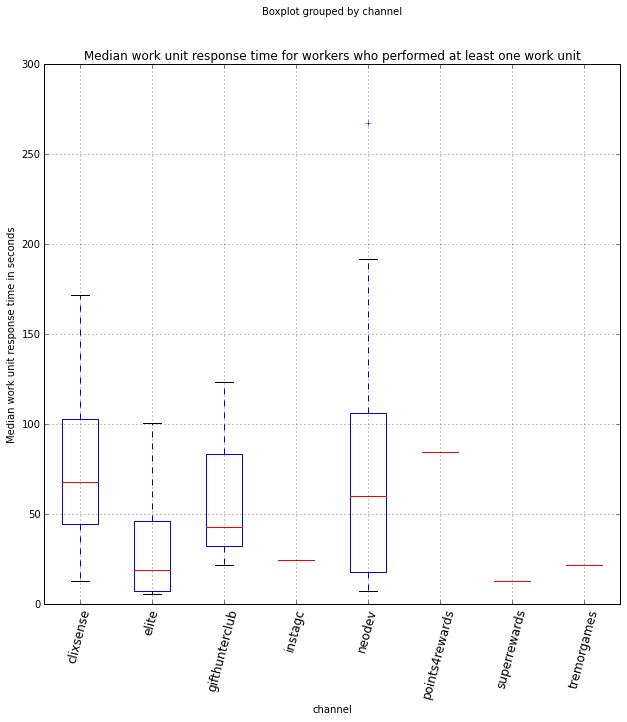

In [29]:
data = worker_profiles.query("work_units_seen > 0")
plot_work_speed("channel", data, "Median work unit response time for workers who performed at least one work unit")

###Find bad workers

Now that we have a profile about every worker who did the job, we can try to find the bad workers.

Signs that a worker may be bad:
1. Only chooses one answer choice for all work units.
2. Evenly distributes answer choices over all possible answers (within some threshold).

In [23]:
def find_bad_workers(raw_data, worker_profiles):
    def equal_distribution(distribution):
        equal_val = distribution.sum() / len(distribution)
        low = 0.95 * equal_val
        high = 1.05 * equal_val
        
        for val in distribution:
            if not (low <= val <= high):
                return False
            
        return True
    
    work_data = raw_data.query("~_golden")
    passed_workers = set(worker_profiles.query("work_units_seen > 0")["worker_id"])

    bad_workers = set()
    for worker_id in passed_workers:
        work_resp = work_data.query("_worker_id == {0}".format(worker_id))
        work_distribution = work_resp["verify_relationship"].value_counts()
        
        if len(work_distribution) == 1:
            bad_workers.add(worker_id)
        elif equal_distribution(work_distribution):
            bad_workers.add(worker_id)
            
    return bad_workers

In [24]:
bad_workers = find_bad_workers(raw_data, worker_profiles)

In [25]:
bad_workers

{31501233,
 31720388,
 31720815,
 32025293,
 33081102,
 33081299,
 33081469,
 33081531,
 33085305,
 33085428,
 33238902,
 33301062,
 33301138,
 33596095}

---

###Look at these bad workers:

In [26]:
res = worker_profiles.query("worker_id in {0}".format(list(bad_workers)))
res = res.sort("work_max_time_per_unit")

In [27]:
res

,channel,country,ip,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_seen,test_yes_direct,...,trust,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
169,neodev,India,27.97.181.134,13.333333,7.666667,7.000000,1,21,31,9,...,0.9355,9.666667,7.666667,7.000000,121,0,121,0,0,33081531
187,neodev,India,27.97.209.28,12.000000,12.000000,7.500000,1,6,10,3,...,0.9000,9.666667,8.250000,7.500000,20,0,20,0,0,33301138
198,neodev,Viet Nam,14.165.100.249,45.833333,45.833333,6.000000,0,6,8,2,...,1.0000,12.333333,9.166667,6.000000,0,5,10,5,0,33596095
168,neodev,India,106.76.56.89,14.166667,7.500000,6.666667,2,34,52,15,...,0.9808,14.000000,7.500000,6.666667,230,0,230,0,0,33081469
170,elite,Viet Nam,125.212.192.29,19.666667,5.916667,5.166667,1,33,46,11,...,0.9565,14.333333,5.833333,5.166667,0,198,198,0,0,33085305
165,neodev,India,106.76.2.22,19.500000,15.000000,7.666667,0,8,11,2,...,1.0000,19.500000,8.333333,7.666667,25,0,25,0,0,33081102
186,neodev,India,112.110.89.25,20.166667,8.666667,7.166667,2,34,52,15,...,0.9423,20.166667,8.333333,7.166667,230,0,230,0,0,33301062
115,elite,Viet Nam,115.76.94.63,24.333333,6.250000,5.000000,1,36,52,14,...,0.9808,24.333333,6.000000,5.000000,0,230,230,0,0,31720815
171,elite,Viet Nam,115.76.94.63,31.000000,11.500000,5.833333,1,8,10,1,...,1.0000,31.000000,13.333333,5.833333,0,17,17,0,0,33085428
130,elite,Viet Nam,210.211.118.133,40.166667,16.833333,11.333333,1,13,18,3,...,1.0000,40.166667,21.916667,11.333333,0,60,60,0,0,32025293


In [28]:
cols = ["work_max_time_per_unit", "work_median_time_per_unit",
        "worker_id", "work_units_seen",
        "work_ner_mistake", "work_no_relation", "work_yes_direct", "work_yes_indirect"]

res[cols]

,work_max_time_per_unit,work_median_time_per_unit,worker_id,work_units_seen,work_ner_mistake,work_no_relation,work_yes_direct,work_yes_indirect
169,9.666667,7.666667,33081531,121,121,0,0,0
187,9.666667,8.250000,33301138,20,20,0,0,0
198,12.333333,9.166667,33596095,10,0,5,5,0
168,14.000000,7.500000,33081469,230,230,0,0,0
170,14.333333,5.833333,33085305,198,0,198,0,0
165,19.500000,8.333333,33081102,25,25,0,0,0
186,20.166667,8.333333,33301062,230,230,0,0,0
115,24.333333,6.000000,31720815,230,0,230,0,0
171,31.000000,13.333333,33085428,17,0,17,0,0
130,40.166667,21.916667,32025293,60,0,60,0,0


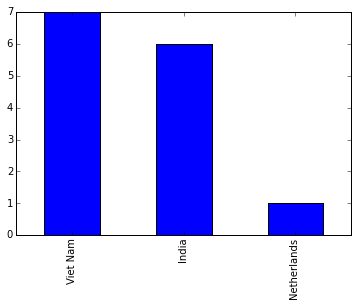

In [29]:
res["country"].value_counts().plot(kind = "bar")

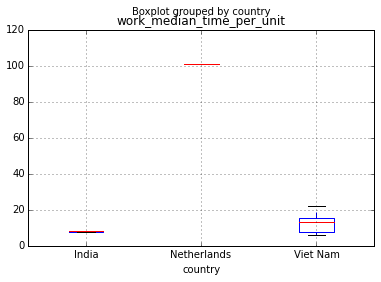

In [30]:
res.boxplot("work_median_time_per_unit", by = "country")

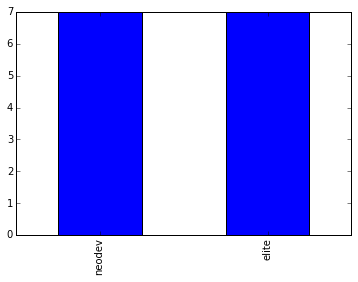

In [31]:
res["channel"].value_counts().plot(kind = "bar")

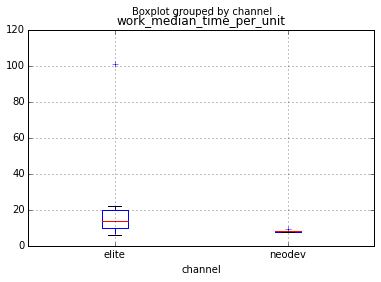

In [32]:
res.boxplot("work_median_time_per_unit", by = "channel")

In [33]:
for worker_id in res["worker_id"]:
    print "https://crowdflower.com/jobs/758438/contributors/{0}".format(worker_id)

https://crowdflower.com/jobs/758438/contributors/33081531
https://crowdflower.com/jobs/758438/contributors/33301138
https://crowdflower.com/jobs/758438/contributors/33596095
https://crowdflower.com/jobs/758438/contributors/33081469
https://crowdflower.com/jobs/758438/contributors/33085305
https://crowdflower.com/jobs/758438/contributors/33081102
https://crowdflower.com/jobs/758438/contributors/33301062
https://crowdflower.com/jobs/758438/contributors/31720815
https://crowdflower.com/jobs/758438/contributors/33085428
https://crowdflower.com/jobs/758438/contributors/32025293
https://crowdflower.com/jobs/758438/contributors/31501233
https://crowdflower.com/jobs/758438/contributors/31720388
https://crowdflower.com/jobs/758438/contributors/33081299
https://crowdflower.com/jobs/758438/contributors/33238902


In [34]:
def sample_worker_responses(job_id, worker_id, raw_data, category = None, sample_size = 10):
    """
    Randomly sample a worker's responses for review by hand.
    """
    test_resp = raw_data.query("_golden and _worker_id == {0}".format(worker_id))
    work_resp = raw_data.query("~_golden and _worker_id == {0}".format(worker_id))
    
    # a specific subcategory of responses
    if category is not None:
        work_resp = work_resp.query("verify_relationship == '{0}'".format(category))
        
    test_sample = test_resp
    work_sample = work_resp
    if len(test_resp) > sample_size:
        test_sample = test_resp.sample(sample_size, random_state = NUMPY_RAND_SEED)
        
    if len(work_resp) > sample_size:
        work_sample = work_resp.sample(sample_size, random_state = NUMPY_RAND_SEED)
    
    print "Worker id:", worker_id
    
    print "Test question sample:"
    for unit_id in test_sample["_unit_id"].unique():
        print "https://crowdflower.com/jobs/{0}/units/{1}".format(job_id, unit_id)

    print "Work question sample:"
    for unit_id in work_sample["_unit_id"].unique():
        print "https://crowdflower.com/jobs/{0}/units/{1}".format(job_id, unit_id)
        
    print "-----------------------------------------------------------------"

In [35]:
sample_worker_responses(758438, 32025293, raw_data)

Worker id: 32025293
Test question sample:
https://crowdflower.com/jobs/758438/units/765528948
https://crowdflower.com/jobs/758438/units/765528956
https://crowdflower.com/jobs/758438/units/765528980
https://crowdflower.com/jobs/758438/units/765528959
https://crowdflower.com/jobs/758438/units/765528955
https://crowdflower.com/jobs/758438/units/765528954
https://crowdflower.com/jobs/758438/units/765528974
https://crowdflower.com/jobs/758438/units/765528933
https://crowdflower.com/jobs/758438/units/765528950
https://crowdflower.com/jobs/758438/units/765528938
Work question sample:
https://crowdflower.com/jobs/758438/units/765528762
https://crowdflower.com/jobs/758438/units/765528552
https://crowdflower.com/jobs/758438/units/765528677
https://crowdflower.com/jobs/758438/units/765528535
https://crowdflower.com/jobs/758438/units/765528406
https://crowdflower.com/jobs/758438/units/765528148
https://crowdflower.com/jobs/758438/units/765528525
https://crowdflower.com/jobs/758438/units/765528495


##Conclusions:

The workers with ids listed above are probably all cheating and using scripts to select answers. At some level it's difficult to determine why they are passing the test; it's possible that they are working together (or have multiple accounts) so that they can collectively see and record the answers to all the test questions. The median and max time needed to make each judgement is also very low for the identified cheaters, which likely means that they are not doing the task properly.

Verification by hand also confirmed that the cheaters identified in this job did not work on the two previous jobs (#755704 and 754530). This is good, but it does not mean that there might not have been cheaters in the previous tasks.

Workers who take the quiz and fail also need to be examined for cheating. Those who take the quiz, but only ever choose one answer choice, and do so very quickly, are very likely to be robots hoping to fail so that they can be told what the correct answer is. These robots need to also be flagged and banned so that they cannot help the other cheating accounts.

###Changes to be made:

1. Increase the minimum time needed to be spent on each work unit from 5 seconds to 20 seconds. This will identify the people who are not really reading the abstract, and will also ensure that the amount of money spammers can make is lowered. However at the current pay rate of 4 cents/work unit, this still means good workers can still earn roughly 12 cents/minute, which is at the guideline of 10 cents/minute minimum. However, this is 4 times less than what the spammers can earn, so hopefully it will not be worth their while.
2. The entirety of Vietnam seems to be cheating on this task if we base things based on their completion speeds. Therefore it might be wise to exclude Vietnam from working on all future tasks.
3. Clixsense, despite having the third most workers who passed the quiz, has no obvious cheaters. The elite and neodev workpools had a large amount of cheaters. If possible, we should ban the elite and neodev channels from India and Vietnam only in the future.